In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

In [2]:
def string_to_int_mapping(strings):
    # Create a dictionary to store string to integer mapping
    string_to_int = {}
    int_sequence = []

    # Assign a unique integer to each unique string
    for string in strings:
        if string not in string_to_int:
            string_to_int[string] = len(string_to_int)  # Assign the next available integer
        # Append the corresponding integer to the sequence
        int_sequence.append(string_to_int[string])

    return int_sequence, string_to_int

In [4]:
# Rotation derived from Procrustes analysis
def center(X_scatter):
    n,m = X_scatter.shape
    x_mean = sum(X_scatter[:,0].tolist())/n
    y_mean = sum(X_scatter[:,1].tolist())/n
    return X_scatter - [x_mean, y_mean]


# https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy
def procrustes_manual(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection != 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}
   
    return d, Z, tform

def get_rotation_angle(rotation_matrix):
    """
    Calculate the rotation angle from a 2x2 rotation matrix.
    """
    angle_rad = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    angle_deg = np.degrees(angle_rad)
    return angle_deg

In [5]:
classes = np.load("Selected_Examples/Selected_Examples/y.npy").tolist()

## First pair

In [7]:
## First pair
file1 = "Selected_Examples/Selected_Examples/random_seed_0/jitter_amount_0.0/layout1.npy"
scatter1 = np.load(file1)
scatter1 = center(scatter1)

file2 = "Selected_Examples/Selected_Examples/random_seed_0/jitter_amount_0.0/layout2.npy"
scatter2 = np.load(file2)
scatter2 = center(scatter2)

df_scatter1 = pd.DataFrame(scatter1, columns=['x', 'y'])
df_scatter1["classes"] = classes

df_scatter2 = pd.DataFrame(scatter2, columns=['x', 'y'])
df_scatter2["classes"] = classes

In [8]:
d, Z, tform = procrustes_manual(scatter1, scatter2)
rotation_angle = get_rotation_angle(tform['rotation'])
print(rotation_angle)

angle_rad = np.deg2rad(rotation_angle)

df_scatter2['x_new'] = df_scatter2['x'] * np.cos(angle_rad) - df_scatter2['y'] * np.sin(angle_rad)
df_scatter2['y_new'] = df_scatter2['x'] * np.sin(angle_rad) + df_scatter2['y'] * np.cos(angle_rad)

74.9968551423935


C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


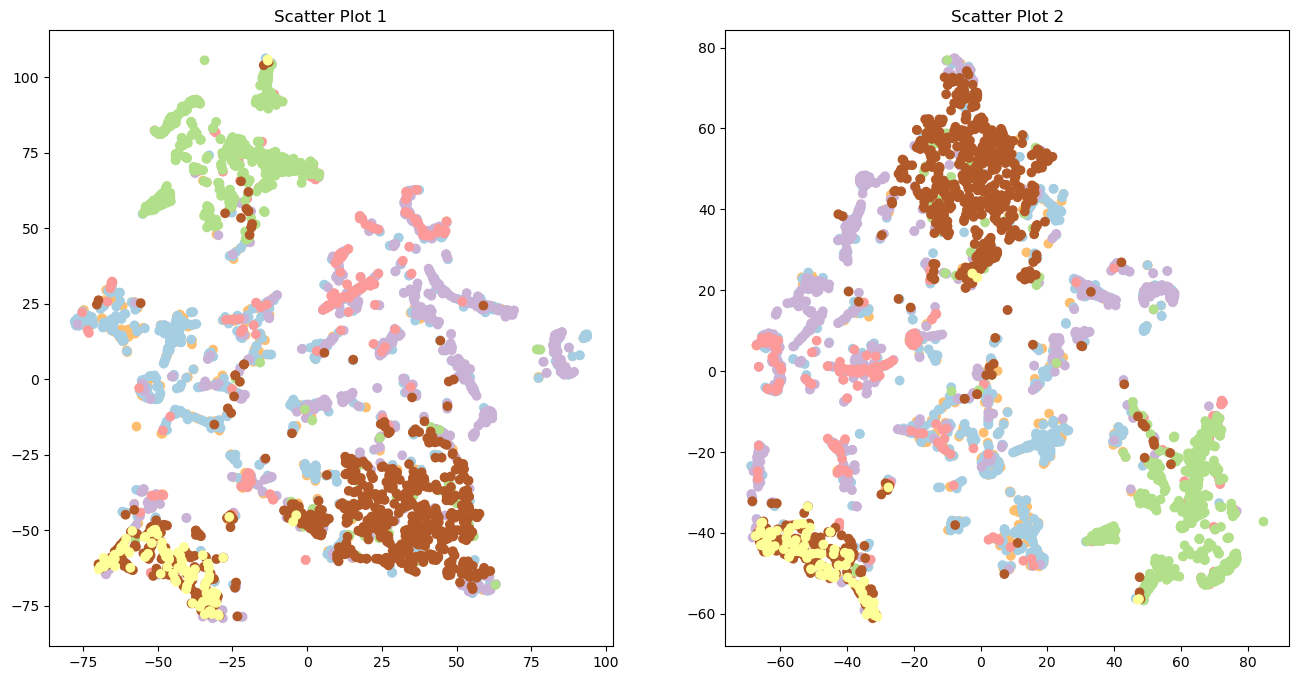

In [9]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x'].tolist(), 
    y=df_scatter2['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


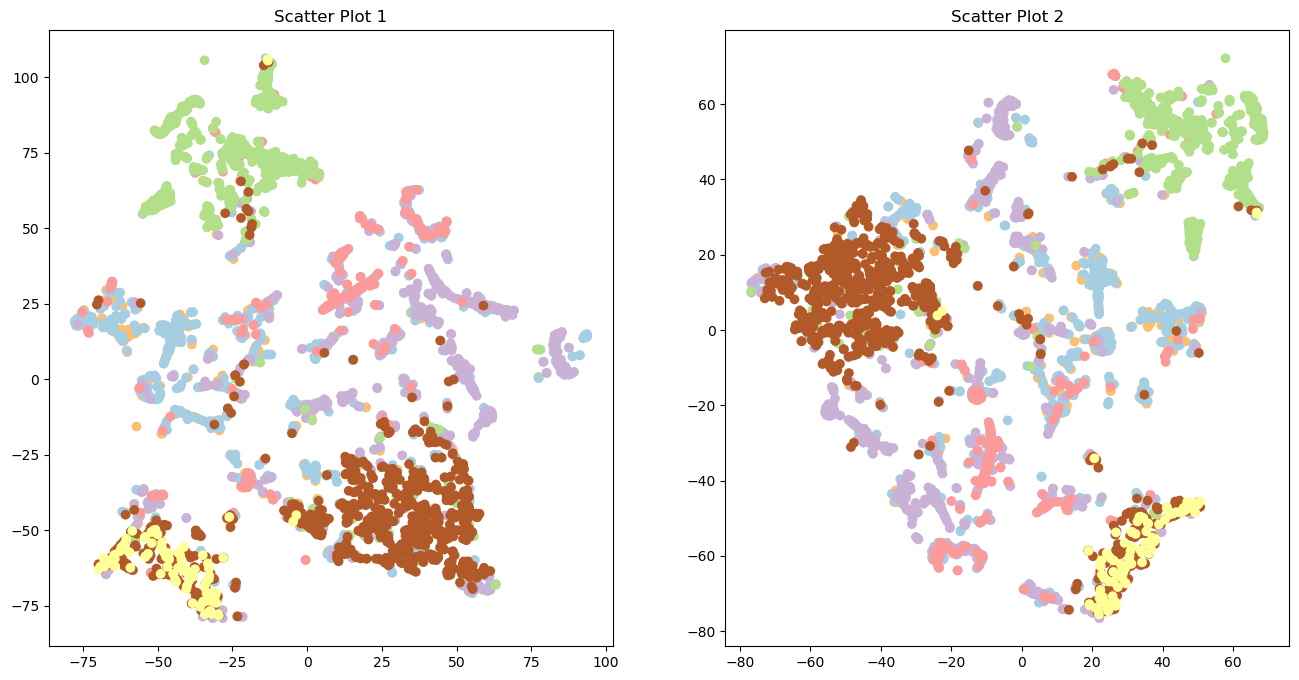

In [10]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x_new'].tolist(), 
    y=df_scatter2['y_new'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

In [11]:
df_scatter1.to_csv("layout1.csv", index = False)
df_scatter2.to_csv("layout2.csv", index = False)

## Second pair

In [12]:
## First pair
file1 = "Selected_Examples/Selected_Examples/random_seed_0/jitter_amount_0.0/layout3.npy"
scatter1 = np.load(file1)
scatter1 = center(scatter1)

file2 = "Selected_Examples/Selected_Examples/random_seed_0/jitter_amount_0.0/layout4.npy"
scatter2 = np.load(file2)
scatter2 = center(scatter2)

df_scatter1 = pd.DataFrame(scatter1, columns=['x', 'y'])
df_scatter1["classes"] = classes

df_scatter2 = pd.DataFrame(scatter2, columns=['x', 'y'])
df_scatter2["classes"] = classes

In [13]:
d, Z, tform = procrustes_manual(scatter1, scatter2)
rotation_angle = get_rotation_angle(tform['rotation'])
print(rotation_angle)

angle_rad = np.deg2rad(rotation_angle)

df_scatter2['x_new'] = df_scatter2['x'] * np.cos(angle_rad) - df_scatter2['y'] * np.sin(angle_rad)
df_scatter2['y_new'] = df_scatter2['x'] * np.sin(angle_rad) + df_scatter2['y'] * np.cos(angle_rad)

10.988294065993058


C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


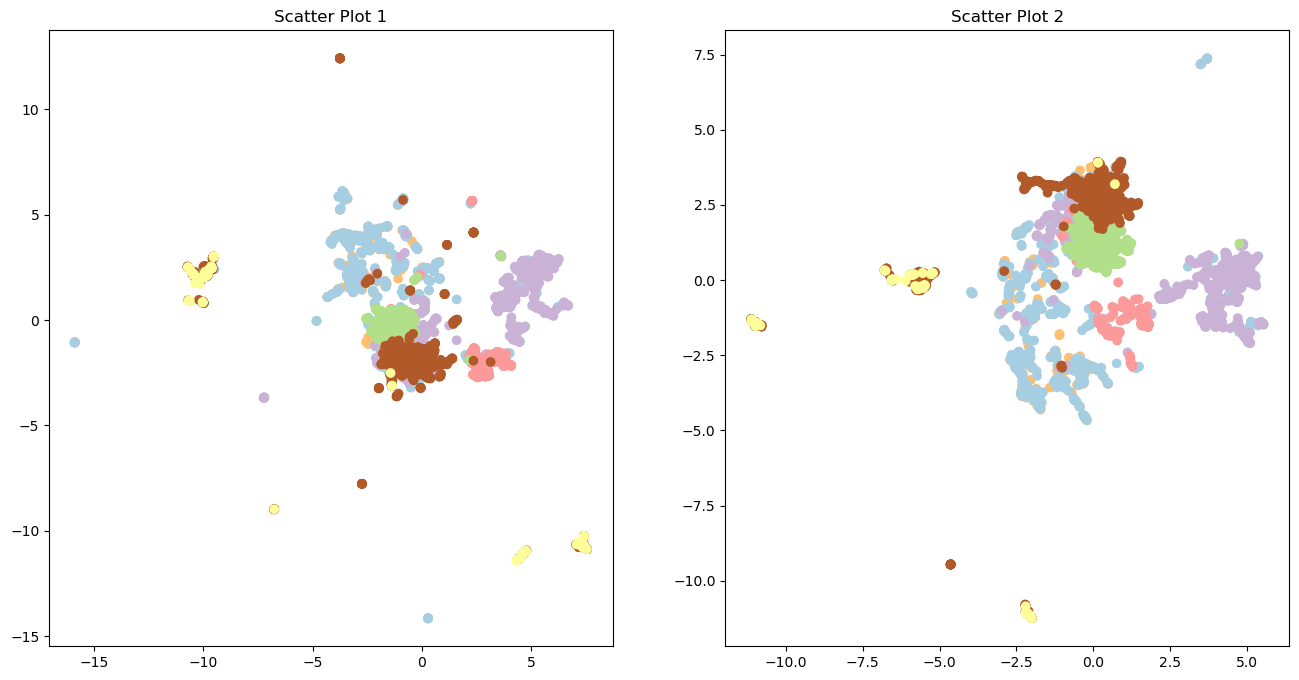

In [14]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x'].tolist(), 
    y=df_scatter2['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


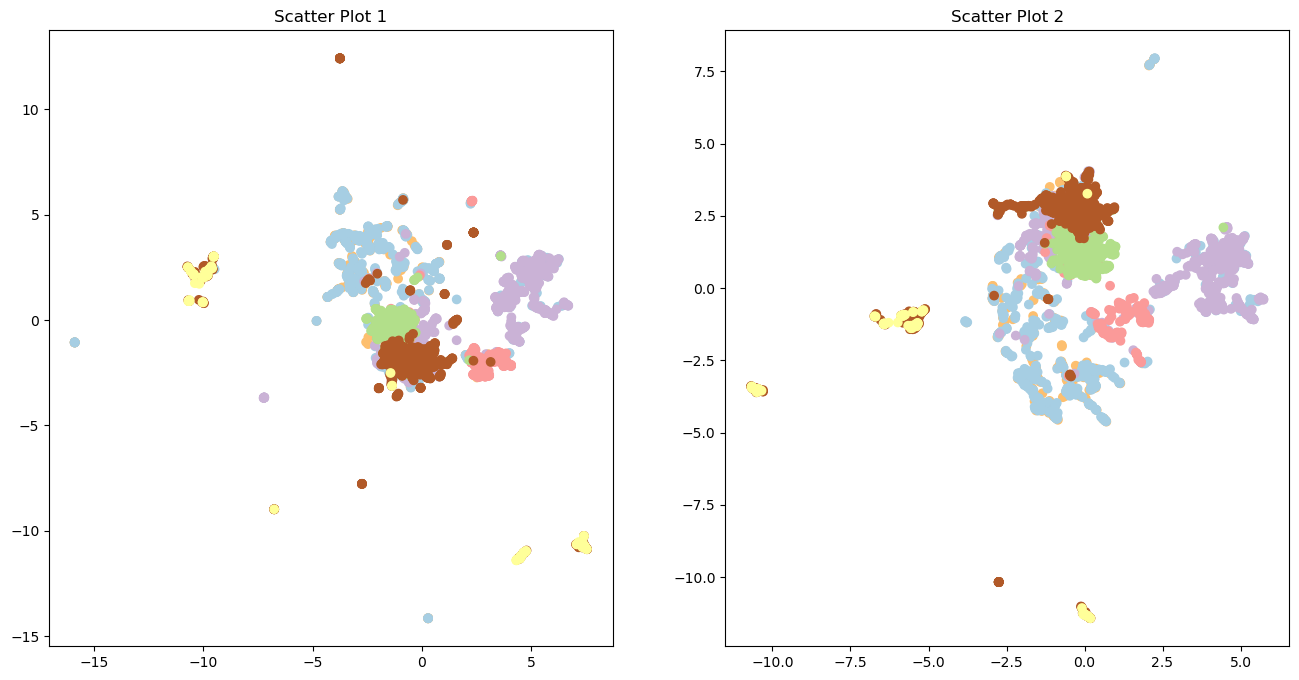

In [15]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x_new'].tolist(), 
    y=df_scatter2['y_new'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

In [16]:
df_scatter1.to_csv("layout3.csv", index = False)
df_scatter2.to_csv("layout4.csv", index = False)

## Third pair

In [17]:
## First pair
file1 = "Selected_Examples/Selected_Examples/random_seed_0/jitter_amount_0.0/layout5.npy"
scatter1 = np.load(file1)
scatter1 = center(scatter1)

file2 = "Selected_Examples/Selected_Examples/random_seed_42/jitter_amount_0.0/layout6.npy"
scatter2 = np.load(file2)
scatter2 = center(scatter2)

df_scatter1 = pd.DataFrame(scatter1, columns=['x', 'y'])
df_scatter1["classes"] = classes

df_scatter2 = pd.DataFrame(scatter2, columns=['x', 'y'])
df_scatter2["classes"] = classes

In [18]:
d, Z, tform = procrustes_manual(scatter1, scatter2)
rotation_angle = get_rotation_angle(tform['rotation'])
print(rotation_angle)

angle_rad = np.deg2rad(rotation_angle)

df_scatter2['x_new'] = df_scatter2['x'] * np.cos(angle_rad) - df_scatter2['y'] * np.sin(angle_rad)
df_scatter2['y_new'] = df_scatter2['x'] * np.sin(angle_rad) + df_scatter2['y'] * np.cos(angle_rad)

-96.96679338141792


C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


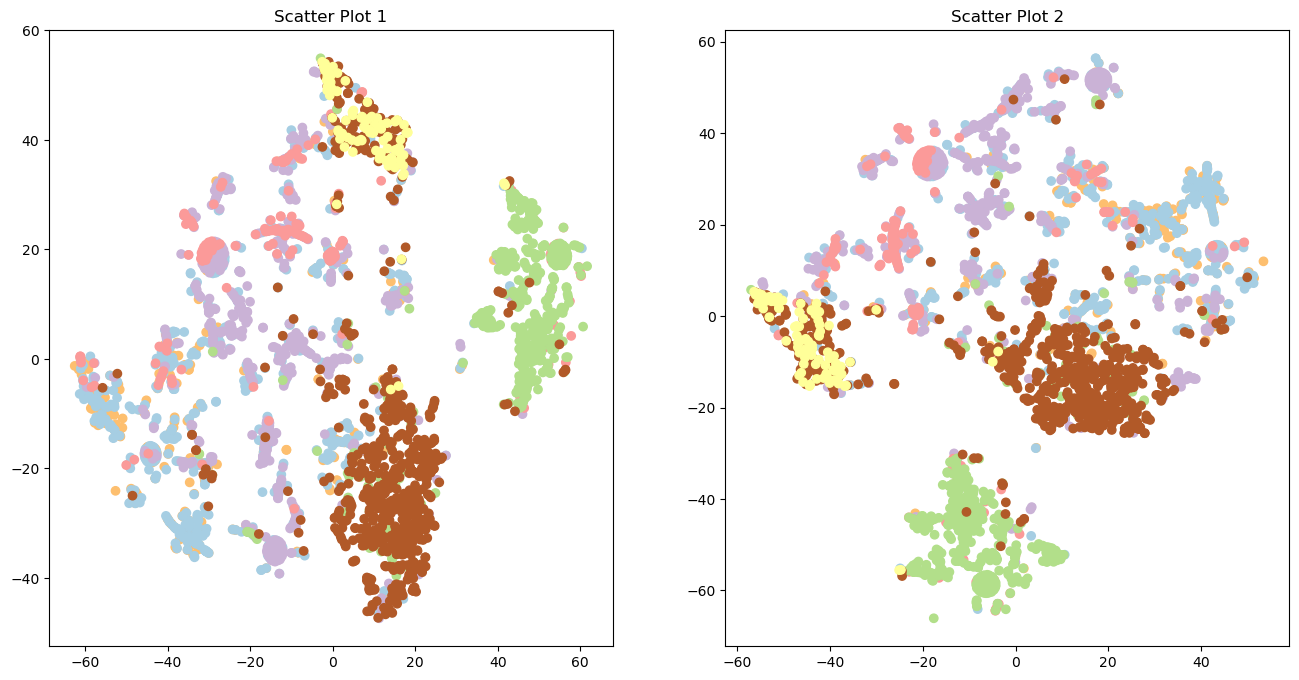

In [19]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x'].tolist(), 
    y=df_scatter2['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


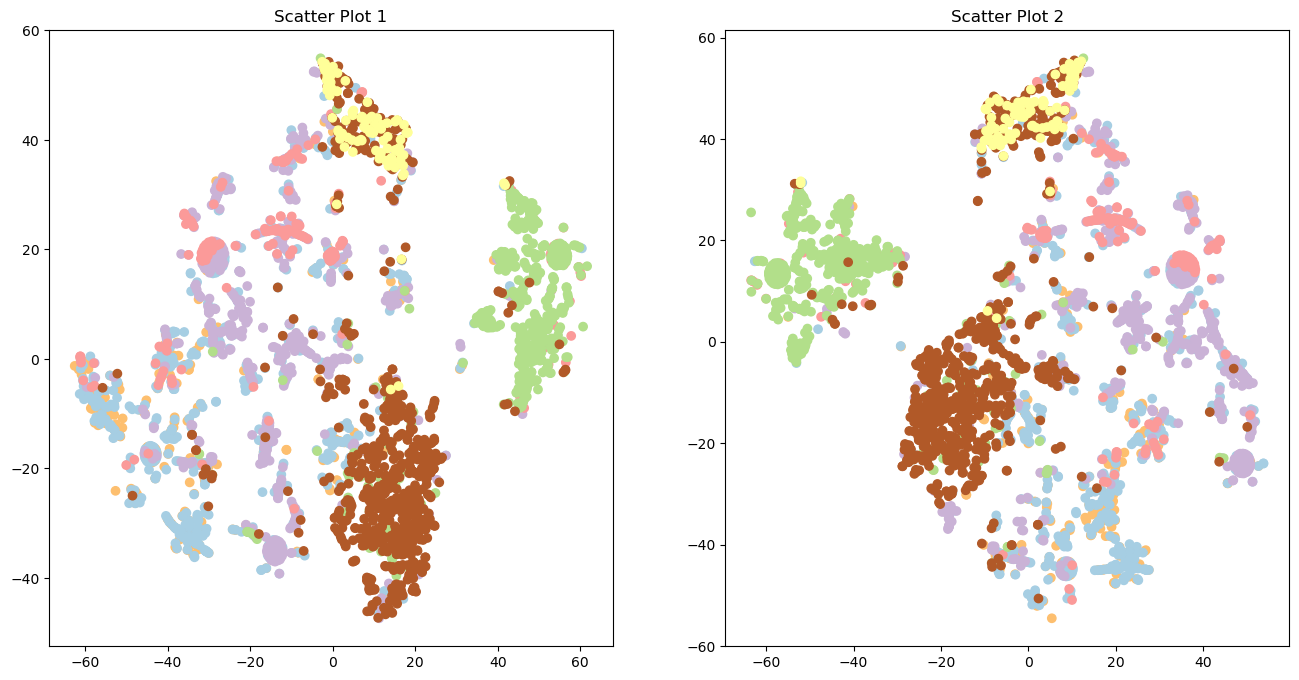

In [20]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x_new'].tolist(), 
    y=df_scatter2['y_new'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

In [21]:
df_scatter1.to_csv("layout5.csv", index = False)
df_scatter2.to_csv("layout6.csv", index = False)

## Fourth pair

In [22]:
## First pair
file1 = "Selected_Examples/Selected_Examples/random_seed_0/jitter_amount_0.0/layout7.npy"
scatter1 = np.load(file1)
scatter1 = center(scatter1)

file2 = "Selected_Examples/Selected_Examples/random_seed_42/jitter_amount_0.0/layout8.npy"
scatter2 = np.load(file2)
scatter2 = center(scatter2)

df_scatter1 = pd.DataFrame(scatter1, columns=['x', 'y'])
df_scatter1["classes"] = classes

df_scatter2 = pd.DataFrame(scatter2, columns=['x', 'y'])
df_scatter2["classes"] = classes

In [23]:
d, Z, tform = procrustes_manual(scatter1, scatter2)
rotation_angle = get_rotation_angle(tform['rotation'])
print(rotation_angle)

angle_rad = np.deg2rad(rotation_angle)

df_scatter2['x_new'] = df_scatter2['x'] * np.cos(angle_rad) - df_scatter2['y'] * np.sin(angle_rad)
df_scatter2['y_new'] = df_scatter2['x'] * np.sin(angle_rad) + df_scatter2['y'] * np.cos(angle_rad)

1.476047236223455


C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


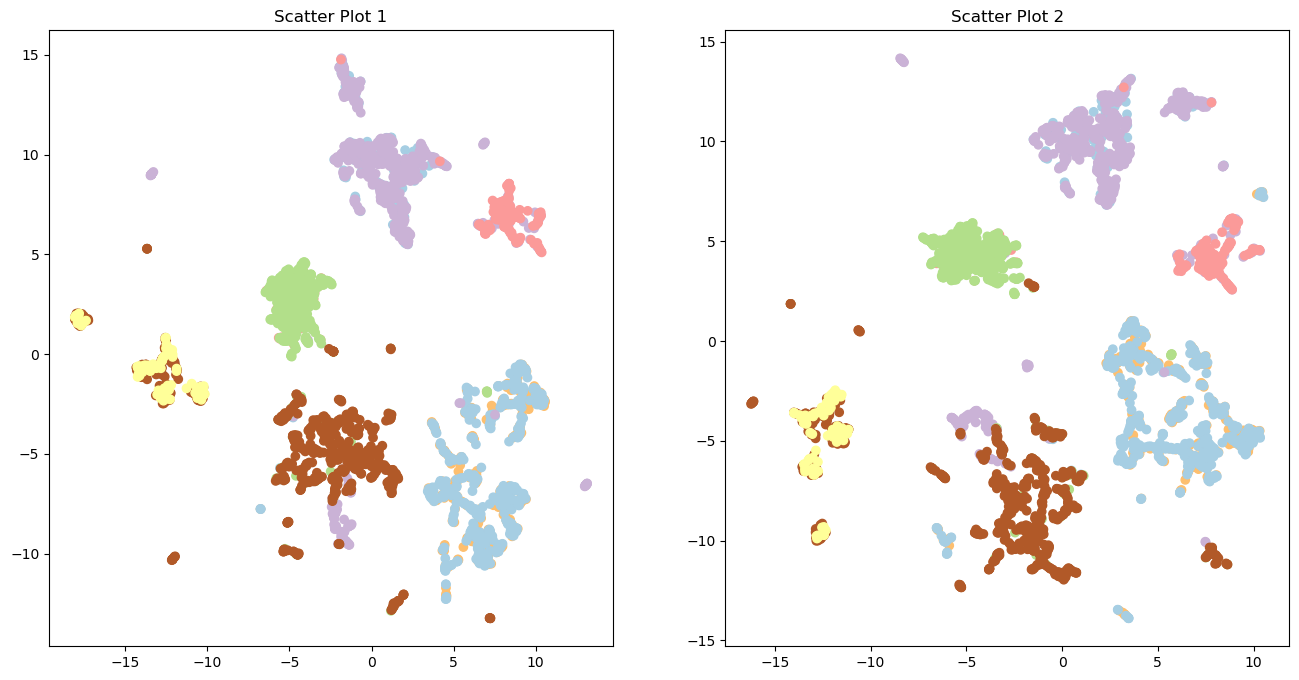

In [24]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x'].tolist(), 
    y=df_scatter2['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


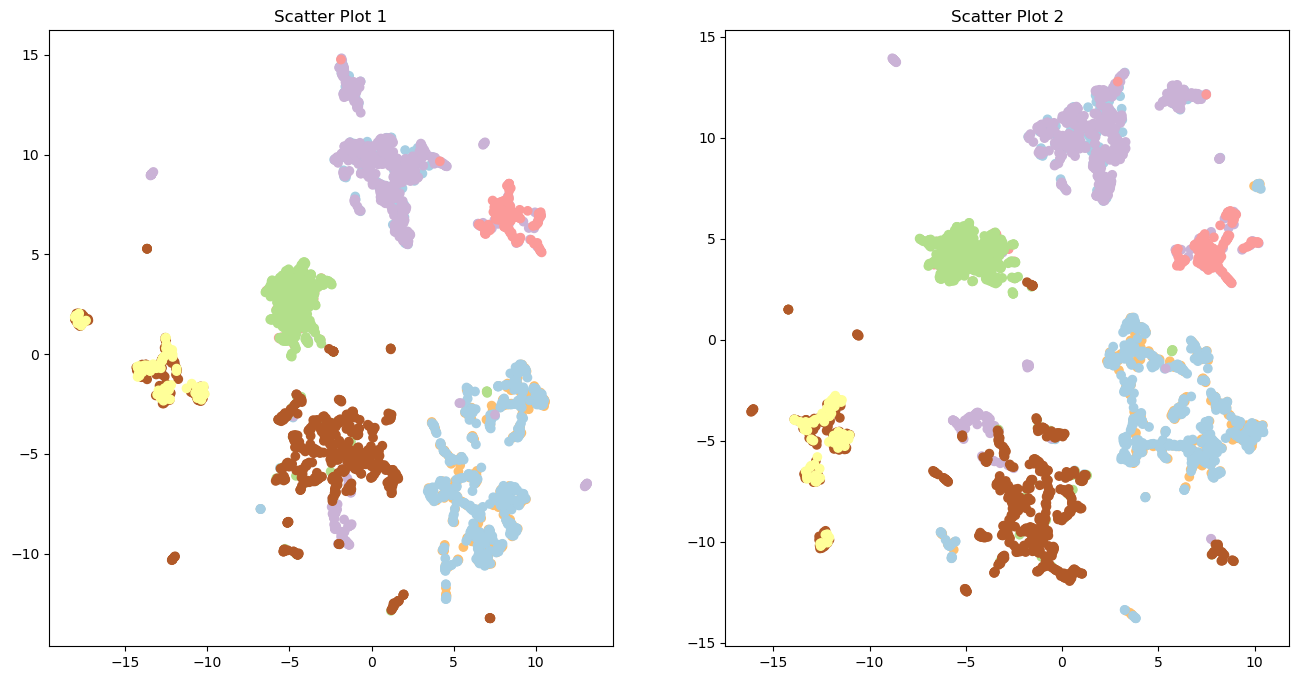

In [25]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x_new'].tolist(), 
    y=df_scatter2['y_new'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

In [26]:
df_scatter1.to_csv("layout7.csv", index = False)
df_scatter2.to_csv("layout8.csv", index = False)

## Fifth pair

In [28]:
## First pair
file1 = "Selected_Examples/Selected_Examples/random_seed_42/jitter_amount_0.0/layout9.npy"
scatter1 = np.load(file1)
scatter1 = center(scatter1)

file2 = "Selected_Examples/Selected_Examples/random_seed_42/jitter_amount_0.25/layout10.npy"
scatter2 = np.load(file2)
scatter2 = center(scatter2)

df_scatter1 = pd.DataFrame(scatter1, columns=['x', 'y'])
df_scatter1["classes"] = classes

df_scatter2 = pd.DataFrame(scatter2, columns=['x', 'y'])
df_scatter2["classes"] = classes

In [29]:
d, Z, tform = procrustes_manual(scatter1, scatter2)
rotation_angle = get_rotation_angle(tform['rotation'])
print(rotation_angle)

angle_rad = np.deg2rad(rotation_angle)

df_scatter2['x_new'] = df_scatter2['x'] * np.cos(angle_rad) - df_scatter2['y'] * np.sin(angle_rad)
df_scatter2['y_new'] = df_scatter2['x'] * np.sin(angle_rad) + df_scatter2['y'] * np.cos(angle_rad)

10.892290927952846


C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


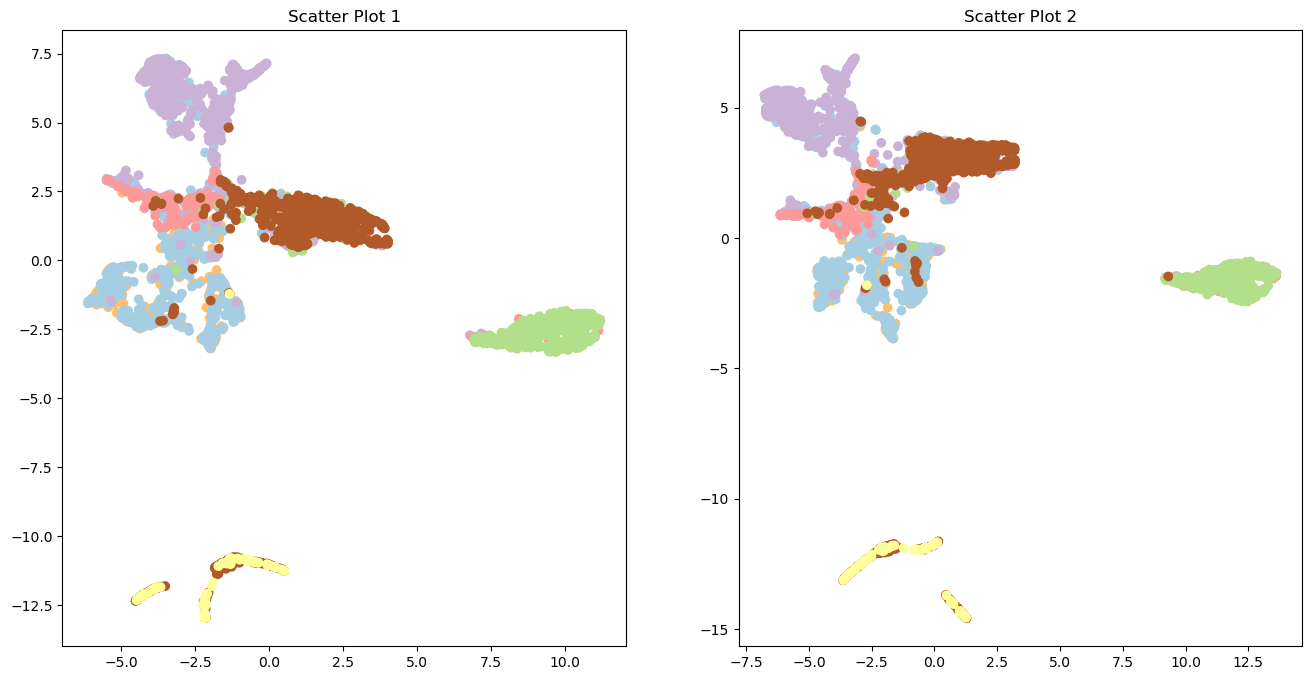

In [30]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x'].tolist(), 
    y=df_scatter2['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


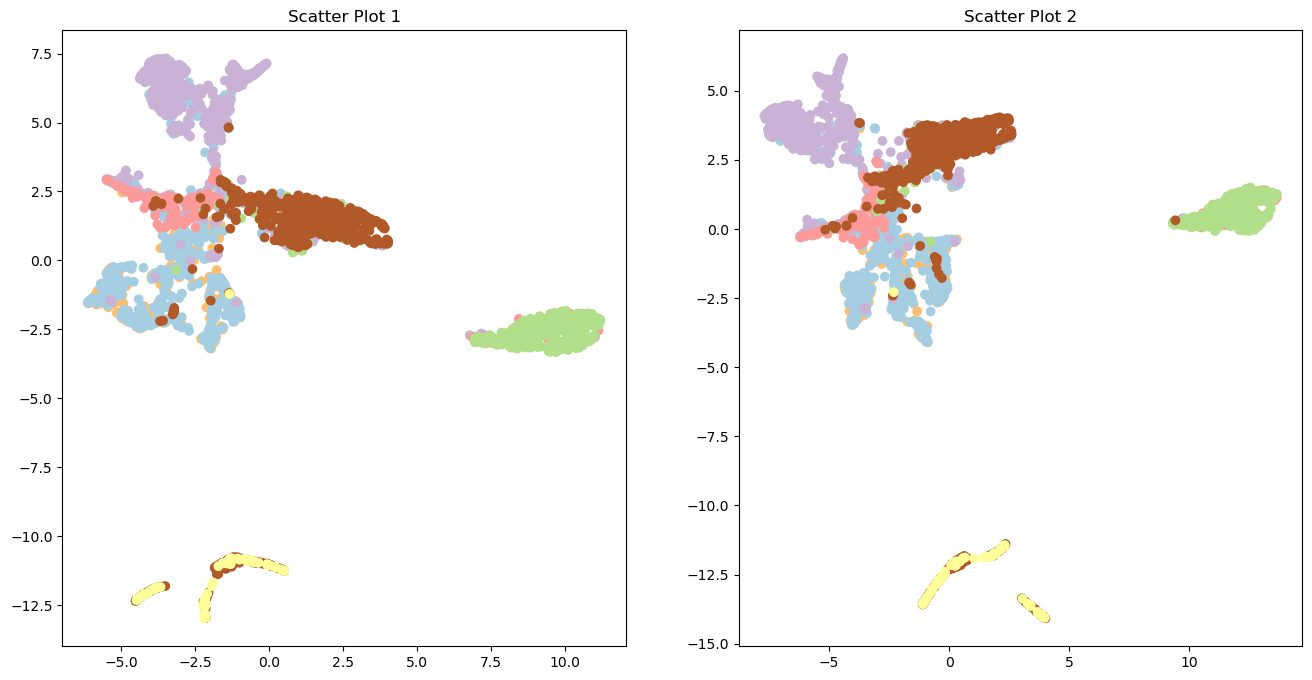

In [31]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x_new'].tolist(), 
    y=df_scatter2['y_new'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

In [32]:
df_scatter1.to_csv("layout9.csv", index = False)
df_scatter2.to_csv("layout10.csv", index = False)

## Sixth pair

In [34]:
## First pair
file1 = "Selected_Examples/Selected_Examples/random_seed_42/jitter_amount_0.0/layout11.npy"
scatter1 = np.load(file1)
scatter1 = center(scatter1)

file2 = "Selected_Examples/Selected_Examples/random_seed_42/jitter_amount_0.25/layout12.npy"
scatter2 = np.load(file2)
scatter2 = center(scatter2)

df_scatter1 = pd.DataFrame(scatter1, columns=['x', 'y'])
df_scatter1["classes"] = classes

df_scatter2 = pd.DataFrame(scatter2, columns=['x', 'y'])
df_scatter2["classes"] = classes

In [35]:
d, Z, tform = procrustes_manual(scatter1, scatter2)
rotation_angle = get_rotation_angle(tform['rotation'])
print(rotation_angle)

angle_rad = np.deg2rad(rotation_angle)

df_scatter2['x_new'] = df_scatter2['x'] * np.cos(angle_rad) - df_scatter2['y'] * np.sin(angle_rad)
df_scatter2['y_new'] = df_scatter2['x'] * np.sin(angle_rad) + df_scatter2['y'] * np.cos(angle_rad)

64.35539137223283


C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\3189341365.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


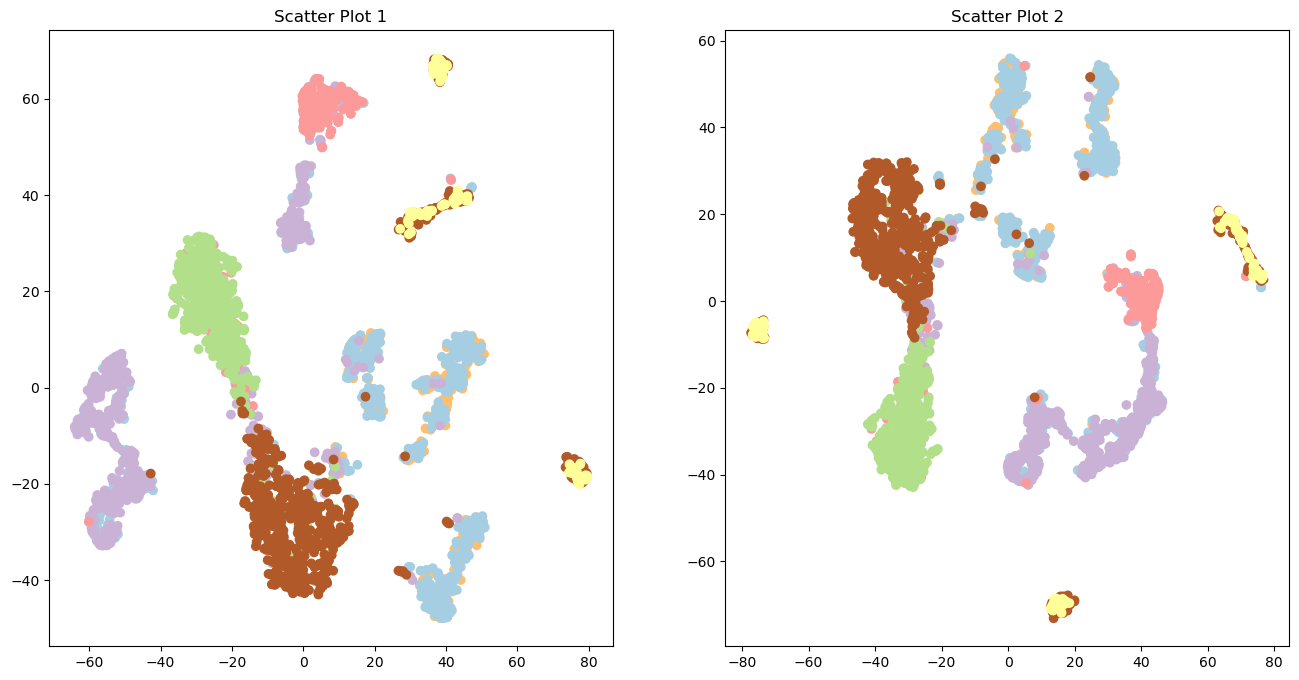

In [36]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x'].tolist(), 
    y=df_scatter2['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),
C:\Users\Daniel Atzberger\AppData\Local\Temp\ipykernel_24792\1597962432.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


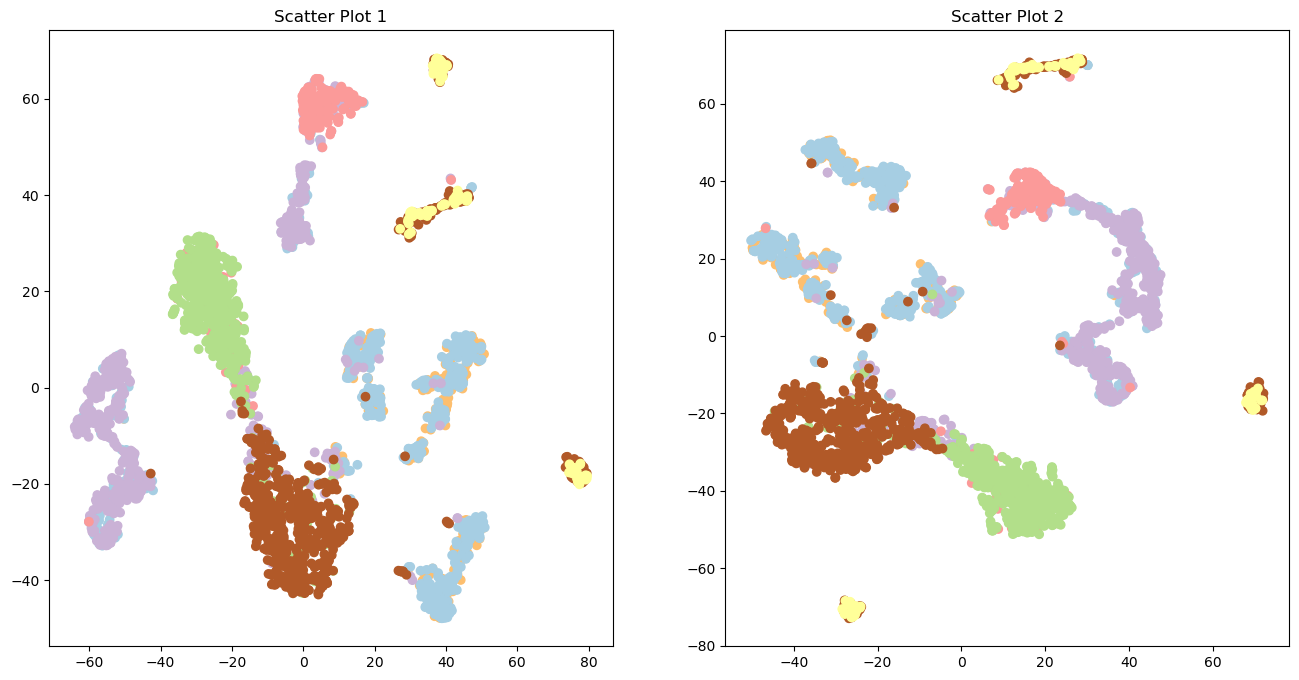

In [37]:
# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First scatter plot
ax1.scatter(
    x=df_scatter1['x'].tolist(), 
    y=df_scatter1['y'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax1.set_title('Scatter Plot 1')

# Second scatter plot
ax2.scatter(
    x=df_scatter2['x_new'].tolist(), 
    y=df_scatter2['y_new'].tolist(), 
    c=classes, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=1.0)
ax2.set_title('Scatter Plot 2')

# Display the plot
plt.show()

In [38]:
df_scatter1.to_csv("layout11.csv", index = False)
df_scatter2.to_csv("layout12.csv", index = False)